# WeRateDogs Wrangling
## [Gather](#gather)
* [Twitter archive file ](#archive)
* [Image prediction file ](#image)
* [Twitter API ](#api)

## [Assess ](#assess)
*  [Visual inspection ](#visual)
*  [Programatic inspection ](#programatic)

## [Clean](#clean)
*  [Define - Quality: Update the data type of timestamp to a timestamp instead of string](#clean1)
*  [Define - Quality: Remove rows that are replies to other tweets](#clean2)
*  [Define - Quality: Remove rows that are retweets ](#clean3)
*  [Define - Quality: Remove reply and retweet columns from the dataframe](#clean4)
*  [Define - Tidiness: Dog stages need to be combined into one column](#clean5)
*  [Define - Quality: Change rating_numerator and rating_denominator to floats](#clean14)
*  [Define Quality: Incorrect values in rating numerators](#clean15)
*  [Define - Tidiness: Join all tweet information into one dataframe](#clean6)
*  [Define - Quality: Drop unused twitter columns](#clean7)
*  [Define - Quality: Drop all rows that do not have retweet or favorite values](#clean8)
*  [Define - Quality: Remove _'s from the p1, p2, and p3 columns](#clean10)
*  [Define - Quality: Capitalize the first letter in each word](#clean11)
*  [Define - Tidiness: Determine the best prediction of dog type](#clean12)
*  [Define - Quality: Remove unused image prediction columns](#clean13)
*  [Merge final datasets into one dataframe for graphs ](#merge)
*  [Create prediction categories ](#categories)
*  [Define - Quality: Drop NA rows in dataframe](#clean16)

## [Analyze](#analyze)
*  [1.Does the dog prediction confidence level have any relation to the number of retweets or favorites?](#question1)
*  [2.Has the prediction confidence changed over time?](#question2)
*  [3. What types of dogs are the most popular on the site?](#question3)

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tweepy
import time

%matplotlib inline

## Gather <a name='gather'></a>

### Twitter archive file  <a name='archive'></a>

In [38]:
# load twitter archive file to df
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### Image prediction file  <a name='image'></a>

In [3]:
# gather image predictions file using requests
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', stream=True)

with open('image-predictions.tsv', 'wb') as fd:
    for chunk in r.iter_content(chunk_size=128):
        fd.write(chunk)
    fd.close()

In [39]:
# load image prediction file to df
df_image_pred = pd.read_csv('image-predictions.tsv', sep='\t')
df_image_pred.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


### Twitter API  <a name='api'></a>

In [5]:
# setup twitter connection with tweepy
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# gather additional tweet data using api
twitter_data = {}
twitter_data['info'] = []

twitter_missing = {}
twitter_missing['ids'] = []

In [7]:
# variables for storing twitter limit information
limit_id = 0
limit_status = 0
limit_time = None
count_processed = 0

# get current limit counts
rate_limit_status = tweepy.API(auth).rate_limit_status()
print('Total : '+str(len(df_image_pred))+' Processed: ' + str(count_processed))

# loop thru all twitter id's to get additional info
for user_id in df_image_pred.tweet_id:
    
    #set limit values
    if limit_id == 0 and limit_status == 0 and limit_time is None:
        rate_limit_status = tweepy.API(auth).rate_limit_status()
        limit_status = rate_limit_status['resources']['application']['/application/rate_limit_status']['remaining']
        limit_time = rate_limit_status['resources']['application']['/application/rate_limit_status']['reset']
        limit_id = rate_limit_status['resources']['statuses']['/statuses/show/:id']['remaining']
        
        print('Status requests: ' + str(limit_status) + \
              ' Record requests: ' + str(limit_id) + \
              ' Time to reset: ' +  time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(limit_time)))
    
    # get tweet info if we are within our limits
    if limit_id > 0:
        try:
            if (limit_id+1) %50 == 0:
                print('Limit: ' + str(limit_id) + ' Remaining: ' + str(len(df_image_pred) - count_processed))
            
            # get and store tweet information
            tweet = tweepy.API(auth).get_status(user_id, tweet_mode='extended')
            twitter_data['info'].append({'tweet_id': tweet.id, 
                    'retweet_count': tweet.retweet_count,
                    'favorite_count': tweet.favorite_count
                    })
            
            # keep track of processed and limit counts
            count_processed += 1
            limit_id -= 1
        except:
            # keep track of twitter id's without information
            twitter_missing['ids'].append({'id': user_id})
            # keep track of processed and limit counts
            count_processed += 1
            limit_id -= 1
    else:
        print('Total : '+str(len(df_image_pred))+' Processed: ' + str(count_processed))
        
        # get latest limit info
        rate_limit_status = tweepy.API(auth).rate_limit_status()
        limit_time = rate_limit_status['resources']['application']['/application/rate_limit_status']['reset']

        # sleep until the limits are available again
        print('Sleeping until: ' + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(limit_time)))
        if (limit_time - time.time()) < 0:
            time.sleep(0)
        else:
            time.sleep(limit_time - time.time())
        
        # get latest limit info
        rate_limit_status = tweepy.API(auth).rate_limit_status()
        limit_time = rate_limit_status['resources']['application']['/application/rate_limit_status']['reset']
        limit_status = rate_limit_status['resources']['application']['/application/rate_limit_status']['remaining']
        limit_id = rate_limit_status['resources']['statuses']['/statuses/show/:id']['remaining']

        print('EXITING sleep, Status remaining: ' + str(limit_status) + \
              ' Record remaining: ' + str(limit_id) + \
              ' Time to reset ' +  time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(limit_time)))

print('Exiting')

Total : 2075 Processed: 0
Status requests: 178 Record requests: 900 Time to reset: 2018-12-01 14:55:49
Limit: 899 Remaining: 2074
Limit: 849 Remaining: 2024
Limit: 799 Remaining: 1974
Limit: 749 Remaining: 1924
Limit: 699 Remaining: 1874
Limit: 649 Remaining: 1824
Limit: 599 Remaining: 1774
Limit: 549 Remaining: 1724
Limit: 499 Remaining: 1674
Limit: 449 Remaining: 1624
Limit: 399 Remaining: 1574
Limit: 349 Remaining: 1524
Limit: 299 Remaining: 1474
Limit: 249 Remaining: 1424
Limit: 199 Remaining: 1374
Limit: 149 Remaining: 1324
Limit: 99 Remaining: 1274
Limit: 49 Remaining: 1224
Total : 2075 Processed: 900
Sleeping until: 2018-12-01 14:55:49
EXITING sleep, Status remaining: 176 Record remaining: 0 Time to reset 2018-12-01 14:55:49
Total : 2075 Processed: 900
Sleeping until: 2018-12-01 14:55:49
EXITING sleep, Status remaining: 174 Record remaining: 0 Time to reset 2018-12-01 14:55:49
Total : 2075 Processed: 900
Sleeping until: 2018-12-01 14:55:49
EXITING sleep, Status remaining: 179 Re

In [8]:
# dump twitter data to file
with open('tweet_json.txt', 'w') as outfile:
    for i in range(len(twitter_data['info'])):
        tweetid = twitter_data['info'][i]['tweet_id']
        retweetcount = twitter_data['info'][i]['retweet_count']
        favoritecount = twitter_data['info'][i]['favorite_count']
        outfile.write(str(tweetid) + ','+str(retweetcount)+','+str(favoritecount)+'\n')

In [9]:
# dump missing twitter data to file
with open('tweet_json_missing.txt', 'w') as outfile:
    for i in range(len(twitter_missing['ids'])):
        missing_id = twitter_missing['ids'][i]['id']
        outfile.write(str(missing_id) + '\n')

In [40]:
df_tweet_json = pd.read_csv('tweet_json.txt',header=None, \
                            names=['tweet_id','retweet_count','favorite_count'])
df_tweet_json.head(1)

,tweet_id,retweet_count,favorite_count
0,666020888022790149,507,2539


In [41]:
df_tweet_json_missing = pd.read_csv('tweet_json_missing.txt',header=None, \
                            names=['missing_id'])
df_tweet_json_missing.head(1)

,missing_id
0,754011816964026368


## Assess  <a name='assess'></a>

### Visual inspection  <a name='visual'></a>

In [42]:
df_twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1446,696490539101908992,6.964887e+17,4.196984e+09,2016-02-08 00:27:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After reading the comments I may have overesti...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
1079,739238157791694849,NaN,NaN,2016-06-04 23:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739238157...,13,10,None,doggo,None,None,None
1907,674447403907457024,NaN,NaN,2015-12-09 04:36:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper just wants a belly rub. This puppe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674447403...,10,10,None,None,None,pupper,None
1880,675006312288268288,NaN,NaN,2015-12-10 17:37:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Mollie. This pic was taken after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675006312...,10,10,Mollie,None,None,pupper,None
62,880095782870896641,NaN,NaN,2017-06-28 16:09:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please don't send in photos without dogs in th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/880095782...,11,10,None,None,None,None,None
854,765222098633691136,NaN,NaN,2016-08-15 16:22:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gromit. He's pupset because there's no...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/765222098...,10,10,Gromit,None,None,None,None
2107,670465786746662913,NaN,NaN,2015-11-28 04:54:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Silly dog here. Wearing bunny ears. Nice long ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670465786...,7,10,None,None,None,None,None
402,824325613288833024,NaN,NaN,2017-01-25 18:38:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Retweet the h*ck out of this 13/10 pupper #Bel...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/824325613...,13,10,None,None,None,pupper,None
1691,681320187870711809,NaN,NaN,2015-12-28 03:46:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Glacier. He's a very happy pup. Loves ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681320187...,11,10,Glacier,None,None,None,None
390,826240494070030336,NaN,NaN,2017-01-31 01:27:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send in any mo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826240494...,11,10,None,None,None,None,None


In [43]:
df_image_pred.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
530,676819651066732545,https://pbs.twimg.com/media/CWSL4W8WsAAE4KU.jpg,2,rain_barrel,0.625555,False,barrel,0.138383,False,Labrador_retriever,0.039465,True
1912,853760880890318849,https://pbs.twimg.com/media/C9kq_bbVwAAuRZd.jpg,1,miniature_pinscher,0.292519,True,Chihuahua,0.120946,True,Rottweiler,0.119490,True
496,675781562965868544,https://pbs.twimg.com/media/CWDbv2yU4AARfeH.jpg,1,Maltese_dog,0.921968,True,West_Highland_white_terrier,0.017811,True,toy_poodle,0.013555,True
1955,864279568663928832,https://pbs.twimg.com/media/C_6JrWZVwAAHhCD.jpg,1,bull_mastiff,0.668613,True,French_bulldog,0.180562,True,Staffordshire_bullterrier,0.052237,True
83,667495797102141441,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,1,Chihuahua,0.143957,True,Christmas_stocking,0.118651,False,ski_mask,0.092482,False
1632,805826884734976000,https://pbs.twimg.com/ext_tw_video_thumb/80582...,1,Siberian_husky,0.248926,True,American_Staffordshire_terrier,0.098313,True,Eskimo_dog,0.080188,True
1746,823269594223824897,https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg,1,Samoyed,0.585441,True,Pomeranian,0.193654,True,Arctic_fox,0.071648,False
345,672272411274932228,https://pbs.twimg.com/media/CVRkLuJWUAAhhYp.jpg,2,pug,0.914685,True,Norwegian_elkhound,0.014982,True,Siamese_cat,0.009221,False
935,703407252292673536,https://pbs.twimg.com/media/CcMBJODUsAI5-A9.jpg,1,doormat,0.201058,False,turnstile,0.088583,False,carton,0.082924,False
177,669214165781868544,https://pbs.twimg.com/media/CUmGu7-UcAA0r3O.jpg,1,minivan,0.435396,False,police_van,0.310143,False,minibus,0.068201,False


In [44]:
df_tweet_json.sample(10)

,tweet_id,retweet_count,favorite_count
1528,789986466051088384,2557,9948
2052,890006608113172480,7213,30214
561,677895101218201600,2245,5040
500,675845657354215424,937,2365
781,689999384604450816,400,1504
1753,825829644528148480,2712,13539
1166,736225175608430592,2966,8538
914,701601587219795968,489,2196
1485,782722598790725632,5928,18508
1164,735991953473572864,1229,3778


### Programatic inspection  <a name='programatic'></a>

In [45]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [46]:
df_image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [47]:
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 3 columns):
tweet_id          2063 non-null int64
retweet_count     2063 non-null int64
favorite_count    2063 non-null int64
dtypes: int64(3)
memory usage: 48.4 KB


In [48]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [49]:
df_image_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [50]:
df_tweet_json.describe()

,tweet_id,retweet_count,favorite_count
count,2.063000e+03,2063.000000,2063.000000
mean,7.381457e+17,2817.846340,8462.124091
std,6.770708e+16,4900.834798,12727.099049
min,6.660209e+17,12.000000,0.000000
25%,6.763473e+17,597.000000,1606.500000
50%,7.117438e+17,1326.000000,3725.000000
75%,7.931430e+17,3254.500000,10600.500000
max,8.924206e+17,84010.000000,164819.000000


## Clean  <a name='clean'></a>

#### Clean df_twitter_final data frame
*  [Define - Quality: Update the data type of timestamp to a timestamp instead of string](#clean1)
*  [Define - Quality: Remove rows that are replies to other tweets](#clean2)
*  [Define - Quality: Remove rows that are retweets ](#clean3)
*  [Define - Quality: Remove reply and retweet columns from the dataframe](#clean4)
*  [Define - Tidiness: Dog stages need to be combined into one column](#clean5)
*  [Define - Quality: Change rating_numerator and rating_denominator to floats](#clean14)
*  [Define Quality: Incorrect values in rating numerators](#clean15)
*  [Define - Tidiness: Join all tweet information into one dataframe](#clean6)
*  [Define - Quality: Drop unused twitter columns](#clean7)
*  [Define - Quality: Drop all rows that do not have retweet or favorite values](#clean8)

#### Clean df_image_pred_final data frame
*  [Define - Quality: Remove _'s from the p1, p2, and p3 columns](#clean10)
*  [Define - Quality: Capitalize the first letter in each word](#clean11)
*  [Define - Tidiness: Determine the best prediction of dog type](#clean12)
*  [Define - Quality: Remove unused image prediction columns](#clean13)
*  [Merge final datasets into one dataframe for graphs ](#merge)
*  [Create prediction categories ](#categories)
*  [Define - Quality: Drop NA rows in dataframe](#clean16)

In [51]:
# create copies of df's for cleaning
df_image_pred_final = df_image_pred.copy()
df_twitter_final = df_twitter_archive.copy()

#### Define - Quality: Update the data type of timestamp to a timestamp instead of string <a name='clean1'></a>

#### Code

In [52]:
df_twitter_final['timestamp'] = pd.to_datetime(df_twitter_final['timestamp'])

#### Test

In [53]:
df_twitter_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

#### Define - Quality: Remove rows that are replies to other tweets <a name='clean2'></a>

#### Code

In [54]:
df_twitter_final = df_twitter_final.query('in_reply_to_status_id == "NaN"')

#### Test

In [55]:
df_twitter_final.query('in_reply_to_status_id != "NaN"')['in_reply_to_status_id'].count()

0

#### Define - Quality: Remove rows that are retweets  <a name='clean3'></a>

#### Code

In [56]:
df_twitter_final = df_twitter_final.query('retweeted_status_id == "NaN"')

#### Test

In [57]:
df_twitter_final.query('retweeted_status_id != "NaN"')['retweeted_status_id'].count()

0

#### Define - Quality: Remove reply and retweet columns from the dataframe <a name='clean4'></a>

#### Code

In [59]:
df_twitter_final.drop(['in_reply_to_status_id','in_reply_to_user_id', 
                       'retweeted_status_id', 'retweeted_status_user_id',
                       'retweeted_status_timestamp'], axis=1, inplace=True)

####  Test

In [60]:
df_twitter_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 213.0+ KB


#### Define - Tidiness: Dog stages need to be combined into one column  <a name='clean5'></a>

#### Code

In [61]:
df_twitter_final['dog_stage'] = df_twitter_final[['doggo','floofer','pupper','puppo']].apply(lambda x: ','.join(x), axis=1)
df_twitter_final['dog_stage'] = df_twitter_final['dog_stage'].apply(lambda x: x.replace(',,,',','))
df_twitter_final['dog_stage'] = df_twitter_final['dog_stage'].apply(lambda x: x.replace(',,',','))
df_twitter_final['dog_stage'] = df_twitter_final['dog_stage'].apply(lambda x: x.lstrip(',').rstrip(','))

#### Test

In [62]:
df_twitter_final['dog_stage'].value_counts()

None,None,None,None        1761
None,None,pupper,None       221
doggo,None,None,None         72
None,None,None,puppo         23
doggo,None,pupper,None        9
None,floofer,None,None        9
doggo,None,None,puppo         1
doggo,floofer,None,None       1
Name: dog_stage, dtype: int64

#### Define - Quality: Change rating_numerator and rating_denominator to floats  <a name='clean14'></a>

#### Code

In [63]:
df_twitter_final['rating_numerator'] = pd.to_numeric(df_twitter_final['rating_numerator'], downcast='float')
df_twitter_final['rating_denominator'] = pd.to_numeric(df_twitter_final['rating_denominator'], downcast='float')

#### Test

In [64]:
df_twitter_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null float32
rating_denominator    2097 non-null float32
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dog_stage             2097 non-null object
dtypes: datetime64[ns](1), float32(2), int64(1), object(9)
memory usage: 213.0+ KB


#### Define Quality: Incorrect values in rating numerators  <a name='clean15'></a>

#### Code

In [65]:
df_twitter_final['rating_numerator'] = df_twitter_final.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)[0].astype('float')
df_twitter_final['rating_denominator'] = df_twitter_final.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)[1].astype('float')

#### Test

In [66]:
df_twitter_final.query('tweet_id == 786709082849828864 \
                         and rating_numerator == 9.75 \
                        and rating_denominator == 10.0')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
695,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,None,None,None,None,"None,None,None,None"


#### Define - Tidiness: Join all tweet information into one dataframe <a name='clean6'></a>

#### Code

In [67]:
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 3 columns):
tweet_id          2063 non-null int64
retweet_count     2063 non-null int64
favorite_count    2063 non-null int64
dtypes: int64(3)
memory usage: 48.4 KB


In [69]:
df_twitter_final = df_twitter_final.merge(df_tweet_json, left_on='tweet_id',
                                          right_on='tweet_id', how='left')

#### Test

In [70]:
df_twitter_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 15 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null float64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dog_stage             2097 non-null object
retweet_count         1966 non-null float64
favorite_count        1966 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(9)
memory usage: 262.1+ KB


#### Define - Quality: Drop unused twitter columns <a name='clean7'></a>

#### Code

In [71]:
df_twitter_final.drop(['source','text','expanded_urls','rating_numerator','rating_denominator',
                      'name','doggo','floofer','pupper','puppo'], axis=1, inplace=True)

#### Test

In [72]:
df_twitter_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 5 columns):
tweet_id          2097 non-null int64
timestamp         2097 non-null datetime64[ns]
dog_stage         2097 non-null object
retweet_count     1966 non-null float64
favorite_count    1966 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 98.3+ KB


#### Define - Quality: Drop all rows that do not have retweet or favorite values <a name='clean8'></a>

In [73]:
df_twitter_final = df_twitter_final.query('retweet_count != "NaN"')
df_twitter_final = df_twitter_final.query('favorite_count != "NaN"')

In [74]:
print('retweet: ' + str(df_twitter_final.query('retweet_count == "NaN"')['retweet_count'].count()))
print('favorite: ' + str(df_twitter_final.query('favorite_count == "NaN"')['favorite_count'].count()))

retweet: 0
favorite: 0


#### Define - Quality: Remove _'s from the p1, p2, and p3 columns <a name='clean10'></a>

#### Code

In [75]:
df_image_pred_final['p1'] = df_image_pred_final['p1'].str.replace("_", " ")
df_image_pred_final['p2'] = df_image_pred_final['p2'].str.replace("_", " ")
df_image_pred_final['p3'] = df_image_pred_final['p3'].str.replace("_", " ")

#### Test

In [76]:
print('p1: ' + str(df_image_pred_final.query('p1.str.contains("_")')['p1'].count()))
print('p2: ' + str(df_image_pred_final.query('p2.str.contains("_")')['p2'].count()))
print('p3: ' + str(df_image_pred_final.query('p3.str.contains("_")')['p3'].count()))

p1: 0
p2: 0
p3: 0


#### Define - Quality: Capitalize the first letter in each word <a name='clean11'></a>

#### Code

In [77]:
df_image_pred_final['p1'] = df_image_pred_final['p1'].str.title()
df_image_pred_final['p2'] = df_image_pred_final['p2'].str.title()
df_image_pred_final['p3'] = df_image_pred_final['p3'].str.title()

#### Test

In [78]:
print('p1: ' + str(df_image_pred_final.query('p1 != p1.str.title()')['p1'].count()))
print('p2: ' + str(df_image_pred_final.query('p2 != p2.str.title()')['p2'].count()))
print('p3: ' + str(df_image_pred_final.query('p3 != p3.str.title()')['p3'].count()))

p1: 0
p2: 0
p3: 0


#### Define - Tidiness: Determine the best prediction of dog type <a name='clean12'></a>

#### Code

In [79]:
dog_pred = []
dog_pred_conf = []

def top_dog_prediction(df_row):
    if df_row['p1_dog'] == True:
        dog_pred.append(df_row['p1'])
        dog_pred_conf.append(df_row['p1_conf'])
    elif df_row['p2_dog'] == True:
        dog_pred.append(df_row['p2'])
        dog_pred_conf.append(df_row['p2_conf'])
    elif df_row['p3_dog'] == True:
        dog_pred.append(df_row['p3'])
        dog_pred_conf.append(df_row['p3_conf'])
    else:
        dog_pred.append(np.nan)
        dog_pred_conf.append(np.nan)

df_image_pred_final.apply(top_dog_prediction, axis=1)
        
df_image_pred_final['dog_pred'] = dog_pred
df_image_pred_final['dog_pred_conf'] = dog_pred_conf

#### Test

In [80]:
print('p1: ' + str(df_image_pred_final.query('p1_dog == True')['p1_dog'].count()) +
      ' match: ' + str(df_image_pred_final.query('p1 == dog_pred and p1_conf == dog_pred_conf')['p1'].count()))
print('p2: ' + str(df_image_pred_final.query('p1_dog == False and p2_dog == True')['p2_dog'].count()) +
      ' match: ' + str(df_image_pred_final.query('p2 == dog_pred and p2_conf == dog_pred_conf')['p2'].count()))
print('p3: ' + str(df_image_pred_final.query('p1_dog == False and p2_dog == False and p3_dog == True')['p3_dog'].count()) +
      ' match: ' + str(df_image_pred_final.query('p3 == dog_pred and p3_conf == dog_pred_conf')['p3'].count()))

p1: 1532 match: 1532
p2: 155 match: 155
p3: 64 match: 64


#### Define - Quality: Remove unused image prediction columns <a name='clean13'></a>

#### Code

In [81]:
df_image_pred_final.drop(['img_num','p1','p1_conf','p2','p2_conf','p3','p3_conf'], axis=1, inplace=True)

#### Test

In [82]:
df_image_pred_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 7 columns):
tweet_id         2075 non-null int64
jpg_url          2075 non-null object
p1_dog           2075 non-null bool
p2_dog           2075 non-null bool
p3_dog           2075 non-null bool
dog_pred         1751 non-null object
dog_pred_conf    1751 non-null float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 71.0+ KB


#### Merge final datasets into one dataframe for graphs  <a name='merge'></a>

In [83]:
df_combined_master = df_twitter_final.merge(df_image_pred_final, left_on='tweet_id', right_on='tweet_id', how='inner')
df_combined_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 0 to 1965
Data columns (total 11 columns):
tweet_id          1966 non-null int64
timestamp         1966 non-null datetime64[ns]
dog_stage         1966 non-null object
retweet_count     1966 non-null float64
favorite_count    1966 non-null float64
jpg_url           1966 non-null object
p1_dog            1966 non-null bool
p2_dog            1966 non-null bool
p3_dog            1966 non-null bool
dog_pred          1662 non-null object
dog_pred_conf     1662 non-null float64
dtypes: bool(3), datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 144.0+ KB


#### Create prediction categories  <a name='categories'></a>

In [84]:
df_combined_master['pred_categories'] = pd.cut(df_combined_master['dog_pred_conf'], 5, labels=[1, 2, 3, 4, 5])
df_combined_master['pred_categories'] = pd.to_numeric(df_combined_master['pred_categories'])
df_combined_master.sample(10)

,tweet_id,timestamp,dog_stage,retweet_count,favorite_count,jpg_url,p1_dog,p2_dog,p3_dog,dog_pred,dog_pred_conf,pred_categories
1261,685641971164143616,2016-01-09 01:59:19,"None,None,pupper,None",835.0,3091.0,https://pbs.twimg.com/media/CYPjvFqW8AAgiP2.jpg,True,True,False,Lakeland Terrier,0.253839,2.0
1602,672964561327235073,2015-12-05 02:23:49,"None,None,None,None",662.0,1450.0,https://pbs.twimg.com/media/CVbZsouWUAIsxMc.jpg,True,True,True,Chihuahua,0.292343,2.0
1065,701889187134500865,2016-02-22 21:59:57,"None,None,None,None",1471.0,3746.0,https://pbs.twimg.com/media/Cb2cfd9WAAEL-zk.jpg,True,True,False,French Bulldog,0.902856,5.0
1907,667090893657276420,2015-11-18 21:23:57,"None,None,None,None",129.0,336.0,https://pbs.twimg.com/media/CUH7oLuUsAELWib.jpg,True,True,True,Chihuahua,0.959514,5.0
1016,706593038911545345,2016-03-06 21:31:22,"None,None,None,None",670.0,2265.0,https://pbs.twimg.com/media/Cc5Snc7XIAAMidF.jpg,False,False,False,NaN,NaN,NaN
605,767884188863397888,2016-08-23 00:40:31,"None,None,None,None",1533.0,5069.0,https://pbs.twimg.com/media/CqgSl4DWcAA-x-o.jpg,False,False,False,NaN,NaN,NaN
166,850380195714523136,2017-04-07 16:10:12,"None,None,None,None",2758.0,13504.0,https://pbs.twimg.com/ext_tw_video_thumb/85038...,True,True,True,Yorkshire Terrier,0.249012,2.0
1775,669571471778410496,2015-11-25 17:40:53,"None,None,None,None",1049.0,1614.0,https://pbs.twimg.com/media/CUrLsI-UsAALfUL.jpg,False,False,False,NaN,NaN,NaN
1123,696877980375769088,2016-02-09 02:07:12,"None,None,pupper,None",761.0,2565.0,https://pbs.twimg.com/media/CavO0uuWEAE96Ed.jpg,False,False,False,NaN,NaN,NaN
743,747816857231626240,2016-06-28 15:40:07,"None,None,None,None",1253.0,5122.0,https://pbs.twimg.com/media/CmDHdCoWkAACTB4.jpg,True,True,True,Pembroke,0.768923,4.0


#### Define - Quality: Drop NA rows in dataframe  <a name='clean16'></a>

#### Code

In [101]:
df_combined_master.dropna(inplace=True)

#### Test

In [105]:
df_combined_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1662 entries, 1 to 1965
Data columns (total 12 columns):
tweet_id           1662 non-null int64
timestamp          1662 non-null datetime64[ns]
dog_stage          1662 non-null object
retweet_count      1662 non-null float64
favorite_count     1662 non-null float64
jpg_url            1662 non-null object
p1_dog             1662 non-null bool
p2_dog             1662 non-null bool
p3_dog             1662 non-null bool
dog_pred           1662 non-null object
dog_pred_conf      1662 non-null float64
pred_categories    1662 non-null float64
dtypes: bool(3), datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 134.7+ KB


### Analyze  <a name='analyze'></a>

In [85]:
df_twitter_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 0 to 2096
Data columns (total 5 columns):
tweet_id          1966 non-null int64
timestamp         1966 non-null datetime64[ns]
dog_stage         1966 non-null object
retweet_count     1966 non-null float64
favorite_count    1966 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 92.2+ KB


In [86]:
df_combined_master.groupby(['pred_categories'])['pred_categories'].count()/df_combined_master['pred_categories'].count()

pred_categories
1.0    0.158845
2.0    0.189531
3.0    0.194946
4.0    0.180505
5.0    0.276173
Name: pred_categories, dtype: float64

In [87]:
df_image_pred_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 7 columns):
tweet_id         2075 non-null int64
jpg_url          2075 non-null object
p1_dog           2075 non-null bool
p2_dog           2075 non-null bool
p3_dog           2075 non-null bool
dog_pred         1751 non-null object
dog_pred_conf    1751 non-null float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 71.0+ KB


In [88]:
df_combined_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 0 to 1965
Data columns (total 12 columns):
tweet_id           1966 non-null int64
timestamp          1966 non-null datetime64[ns]
dog_stage          1966 non-null object
retweet_count      1966 non-null float64
favorite_count     1966 non-null float64
jpg_url            1966 non-null object
p1_dog             1966 non-null bool
p2_dog             1966 non-null bool
p3_dog             1966 non-null bool
dog_pred           1662 non-null object
dog_pred_conf      1662 non-null float64
pred_categories    1662 non-null float64
dtypes: bool(3), datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 159.4+ KB


In [89]:
#write dataframes to files
df_twitter_final.to_csv('df_twitter_final.csv',index=False)
df_image_pred_final.to_csv('df_image_pred_final.csv',index=False)
df_combined_master.to_csv('twitter_archive_master.csv',index=False)

#### 1. Does the dog prediction confidence level have any relation to the number of retweets or favorites? <a name='question1'></a>

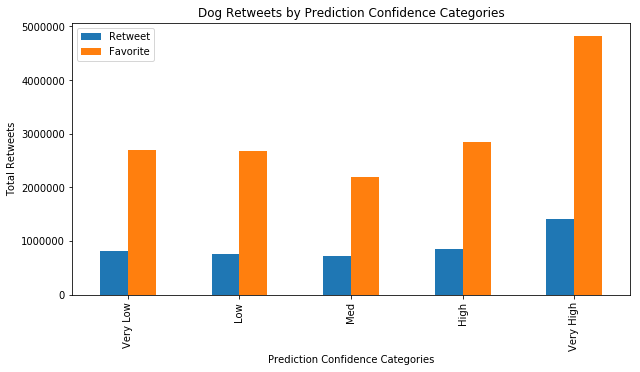

In [106]:
#fig, ax = plt.subplots();
retweet = df_combined_master.groupby(['pred_categories'])['retweet_count'].sum()
favorite = df_combined_master.groupby(['pred_categories'])['favorite_count'].sum()
categories = df_combined_master['pred_categories'].unique()

df_sums = pd.DataFrame({'Retweet': retweet, 'Favorite': favorite}, index=categories)

#y = df_combined_master.groupby(['pred_categories'])['retweet_count'].sum()

ax = df_sums.plot.bar(figsize=(10,5))

ax.set_xlabel('Prediction Confidence Categories')
ax.set_xticklabels(['Very Low','Low','Med','High','Very High'])
ax.set_ylabel('Total Retweets')
ax.set_title('Dog Retweets by Prediction Confidence Categories');

In [117]:
retweet, categories, favorite, categories

(pred_categories
 1.0     724632.0
 2.0     812402.0
 3.0     843549.0
 4.0     756040.0
 5.0    1410919.0
 Name: retweet_count, dtype: float64,
 array([2., 4., 1., 3., 5.]),
 pred_categories
 1.0    2191100.0
 2.0    2702878.0
 3.0    2842052.0
 4.0    2668863.0
 5.0    4827354.0
 Name: favorite_count, dtype: float64,
 array([2., 4., 1., 3., 5.]))

#### 2. Has the prediction confidence changed over time?  <a name='question2'></a>

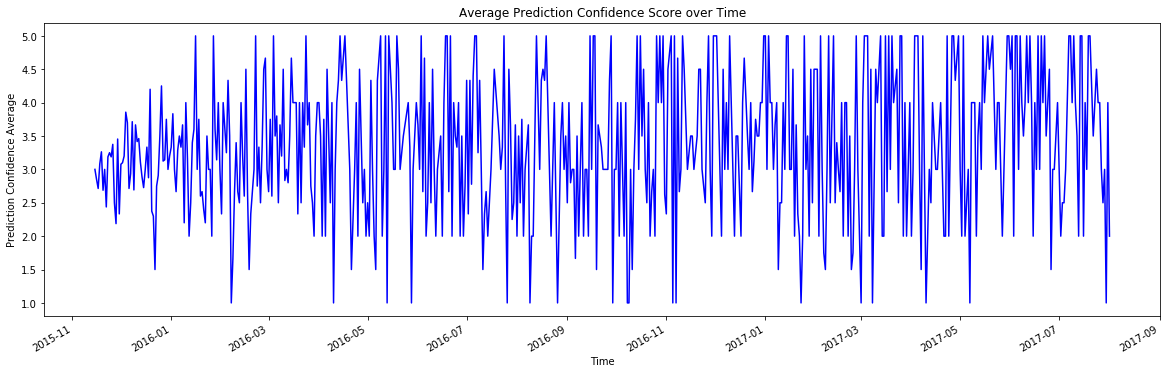

In [107]:
#get specific data for graph
data = df_combined_master[['timestamp','pred_categories']]
data = pd.DataFrame(data=data)

#remove the time in the timestamp
data['date'] = pd.DatetimeIndex(data.timestamp).normalize()

#change data type
data['pred_categories'] = pd.to_numeric(data['pred_categories'])

df_time_cat = data.groupby('date')['pred_categories'].mean()
df_time_cat = pd.DataFrame(data=df_time_cat)

fig, ax = plt.subplots();

df_time_cat['pred_categories'].plot(color='blue',label='Prediction Categories', figsize=(20,6))

ax.set_xlabel('Time')
ax.set_ylabel('Prediction Confidence Average')
ax.set_title('Average Prediction Confidence Score over Time');

In [108]:
# overall average
data['pred_categories'].mean()

3.2256317689530687

#### 3. What types of dogs are the most popular on the site?  <a name='question3'></a>

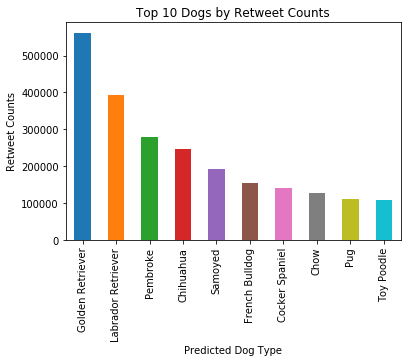

In [109]:
# most retweeted dogs
retweet_sum = df_combined_master.groupby('dog_pred')['retweet_count'].sum()
ax = retweet_sum.sort_values(ascending=False)[:10].plot.bar()
ax.set_xlabel('Predicted Dog Type')
ax.set_ylabel('Retweet Counts')
ax.set_title('Top 10 Dogs by Retweet Counts');

In [114]:
retweet_sum.sort_values(ascending=False)[:10]

dog_pred
Golden Retriever      561591.0
Labrador Retriever    392047.0
Pembroke              278983.0
Chihuahua             247281.0
Samoyed               191958.0
French Bulldog        155694.0
Cocker Spaniel        140600.0
Chow                  126892.0
Pug                   112181.0
Toy Poodle            109446.0
Name: retweet_count, dtype: float64

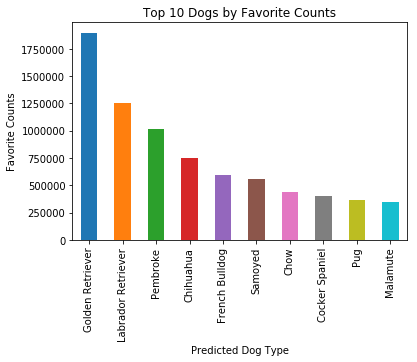

In [110]:
# most favorited dogs
favorite_sum = df_combined_master.groupby('dog_pred')['favorite_count'].sum()
ax_fav = favorite_sum.sort_values(ascending=False)[:10].plot.bar()
ax_fav.set_xlabel('Predicted Dog Type')
ax_fav.set_ylabel('Favorite Counts')
ax_fav.set_title('Top 10 Dogs by Favorite Counts');

In [115]:
favorite_sum.sort_values(ascending=False)[:10]

dog_pred
Golden Retriever      1896894.0
Labrador Retriever    1255976.0
Pembroke              1019732.0
Chihuahua              750738.0
French Bulldog         591064.0
Samoyed                562130.0
Chow                   441153.0
Cocker Spaniel         399825.0
Pug                    369305.0
Malamute               344943.0
Name: favorite_count, dtype: float64

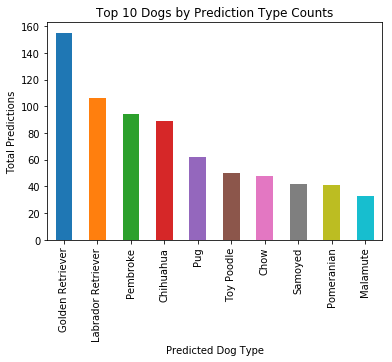

In [111]:
# most posted dogs
dog_sum = df_combined_master.groupby('dog_pred')['dog_pred'].count()
ax_dog = dog_sum.sort_values(ascending=False)[:10].plot.bar()
ax_dog.set_xlabel('Predicted Dog Type')
ax_dog.set_ylabel('Total Predictions')
ax_dog.set_title('Top 10 Dogs by Prediction Type Counts');

In [116]:
dog_sum.sort_values(ascending=False)[:10]

dog_pred
Golden Retriever      155
Labrador Retriever    106
Pembroke               94
Chihuahua              89
Pug                    62
Toy Poodle             50
Chow                   48
Samoyed                42
Pomeranian             41
Malamute               33
Name: dog_pred, dtype: int64